<a href="https://colab.research.google.com/github/wanderson42/Portfolio-DS/blob/main/Projeto_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Data Science - Turing USP** 

# **Projeto de Portfólio Nº 4:** 

<span style='color:Gray'> Montagem de uma classificação usando Pipeline do Sklearn (KNN, Naive Bayes e Decision Tree).  </span>

Predizendo a inadimplência de clientes: German Credit dataset


Autor: Wanderson Ferreira

## **1. Introdução: Informações sobre o Dataset**

</div>
<left><img src="https://raw.githubusercontent.com/wanderson42/portfolio-data/main/credit_risk.jpg" width="900"/> <center>
</div>

<p><center>Imagem meramente ilustrativa</center></p>


O presente dataset é constituido por uma serie de atributos sociodemográficos que descrevem o perfil individual de uma carteira de 1000 clientes residentes na Alemanha que tiveram uma carta de crédito aprovada para financiar a compra de um determinado bem de consumo. O dataset original contém 20 atributos numéricos/categóricos. Nesse caso, foi utilizado uma versão simplificada do dataset contendo 10 atributos. O link para o dataset original pode ser encontrado abaixo.

**Fonte do dataset:** https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)

Cada instância do dataset (linha) representa uma pessoa que recebeu uma carta de crédito. Dentre todos os atributos do dataset (colunas) temos o atributo `risk` de natureza binária, que classifica se o cliente é um bom ou mau pagador das prestações. 

**Descrição do dataset:**

> - **age:** Idade do cliente;
>
> - **sex:** Male ou Female;
>
> - **job:** Tipo de emprego do cliente: unskilled and non-resident, unskilled and resident, skilled, highly skilled;
>
> - **housing:** Tipo de moradia: own, rent, free;
>
> - **saving_accounts:** "Tamanho" da conta poupança:  little, moderate, quite rich, rich;
>
> - **checking_account:** "Tamanho" da conta corrente:  little, moderate, rich;
> - **credit_amount:** Valor da carta de crédito fornecida para o cliente;
>
> - **duration:** Tempo previsto para quitação da divida (em meses);
>
> - **purpose:** Finalidade do crédito: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others;
própria (sim/não);
>
> - **risk:** Bom ou mal pagador.

Com base na lista de atributos acima, o objetivo geral deste presente projeto de portfólio é a construção de um modelo preditivo de classificação, via Pipeline do Sklearn, que auxilie a gerência de um banco na tomada de decisão em aprovar ou não a concessão de uma carta de crédito, identicando potenciais clientes bons pagadores, com base nos seus respectivos perfis, e com isto, minimizar os riscos de inadimplência.

As seguintes abordagens foram levadas em conta para desenvolver a classificação binaria:

> - **Regressão Logistica**
>
> - **K-Nearest Neighbor**
>
> - **Naive Bayes** 

## **2. Importando Bibliotecas de Ciência de Dados**

In [ ]:
%%capture
! pip install category_encoders
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
import matplotlib.style as style
import seaborn as sns
from scipy import stats

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer 
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import set_config
from sklearn import metrics
from sklearn.metrics import make_scorer, accuracy_score, recall_score, precision_score, fbeta_score


from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

## **3. Carregando o dataset**



In [ ]:
#Dataset
url = 'https://raw.githubusercontent.com/wanderson42/Portfolio-DS/main/datasets/german_credit_data.csv'
df = pd.read_csv(url, index_col=0)

 Como parte da investigação inicial, segue abaixo uma ánalise explotória dos dados (EDA - Exploratory Data Analysis), para melhor definirmos a estrutura do Pipeline e consequentemente a obtenção de um bom modelo de classificação.

## **4. Exploratory Data Analysis (EDA): Uma inspeção dos nossos dados**

**4.1 Noção geral da estrutura do dataset**

In [ ]:
#Primeiras impressões sobre o dataframe
display(df.sample(n = 8).style.background_gradient(cmap = 'Set3')); print(); display(df.info())

,age,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose,risk
149,46,male,skilled,own,rich,nan,1582,18,radio/TV,good
314,29,male,unskilled_&_resident,own,nan,rich,1494,4,car,good
702,47,female,skilled,free,moderate,rich,1377,24,radio/TV,good
47,23,female,unskilled_&_non-resident,rent,quite rich,little,1352,6,car,good
447,35,male,skilled,own,little,moderate,2576,7,radio/TV,good
887,23,male,skilled,own,little,moderate,15672,48,business,bad
161,30,female,skilled,own,little,nan,1055,18,car,good
743,22,male,skilled,own,quite rich,little,2483,24,furniture/equipment,good



<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   age               1000 non-null   int64 
 1   sex               1000 non-null   object
 2   job               1000 non-null   object
 3   housing           1000 non-null   object
 4   saving_accounts   817 non-null    object
 5   checking_account  606 non-null    object
 6   credit_amount     1000 non-null   int64 
 7   duration          1000 non-null   int64 
 8   purpose           1000 non-null   object
 9   risk              1000 non-null   object
dtypes: int64(3), object(7)
memory usage: 85.9+ KB


None

> - Dentre as 10 features do dataset, um total de 3 features são do tipo int64 e 7 features são do tipo objeto;
>
> - As features `saving_accounts` e `checking_account` são as duas únicas que apresentam valores ausentes.

**4.2 Inspecionando valores ausentes (NaN)**

In [ ]:
def f1():
  # Calculando o valor total de Nan values no dataset de treino
  df_total_nan = df.isnull().sum()
  df_percent_nan = ((df.isnull().sum()/df.shape[0])*100)
  # Construindo uma tabela de missing values 
  table_missing_data = pd.concat([df_total_nan,df_percent_nan], axis=1, keys=['NaN', 'NaN(%)'], sort = True)
  # Somando todos os missing values de ambas as colunas
  a = table_missing_data['NaN'].sum(); b = a*100/(df.shape[0])
  # Adicionando uma linha contento os valores totais
  row = pd.Series({'NaN':a,'NaN(%)':b},name='Total')
  table_missing_data = table_missing_data.append(row)
  table_missing_data = table_missing_data.astype(int)
  return display(table_missing_data.style.bar(color = 'salmon'))

f1()

,NaN,NaN(%)
age,0,0
checking_account,394,39
credit_amount,0,0
duration,0,0
housing,0,0
job,0,0
purpose,0,0
risk,0,0
saving_accounts,183,18
sex,0,0


> -  A feature `checking_account` possui 394 (39%) valores ausentes;
>
> - A feature `saving_accounts` possui 183 (18%) valores ausentes.
>
> - O dataset totaliza 577 (57%) instâncias contendo algum valor ausente;

Prosseguindo com a EDA, agora seguimos com uma análise estatística mulvariada: 

**4.3 Analise estatistica multivariada das features numéricas**


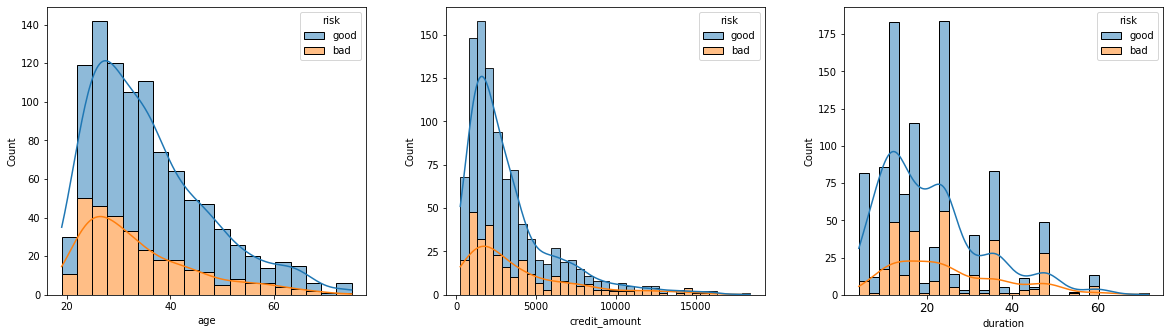

In [ ]:
plt.figure(figsize=(20, 18))

plt.subplot(331)
ax1 = sns.histplot(data = df, x = 'age', hue="risk", palette='tab10', multiple='stack', kde=True)

plt.subplot(332)
ax2 = sns.histplot(data = df, x = 'credit_amount', hue="risk", palette='tab10', multiple='stack', kde=True)

plt.subplot(333)
ax3 = sns.histplot(data = df, x = 'duration', hue="risk", palette= 'tab10', multiple='stack', kde=True)

plt.rcParams.update({'font.size': 16})
plt.xticks(fontsize=12)
plt.subplots_adjust(wspace=0.25)
plt.show()

Conforme a distribuição de dados nos histogramas acima, pode-se destacar, que:

> - Os clientes com idade (`age`) entre 25 e 45 anos são mais propensos a solicitar uma carta de crédito. E proporcionalmente a maior parte dos inadimplentes corresponde a essa faixa etária;
> 
> - A maioria dos clientes são menos propensos a solicitar uma carta de crédito com valor muito alto (`credit_amount`). E esses emprestimos com valores girando em torno de até 4000 são os que proporcionalmente tem o menor risco de inadimplência;
> 
> - Clientes com o prazo de quitação da carta de crédito em até 24 meses (`duration`), proporcionalmente oferecem menos risco de inadimplência.


**4.4 Analise estatistica multivariada de features categóricas:**


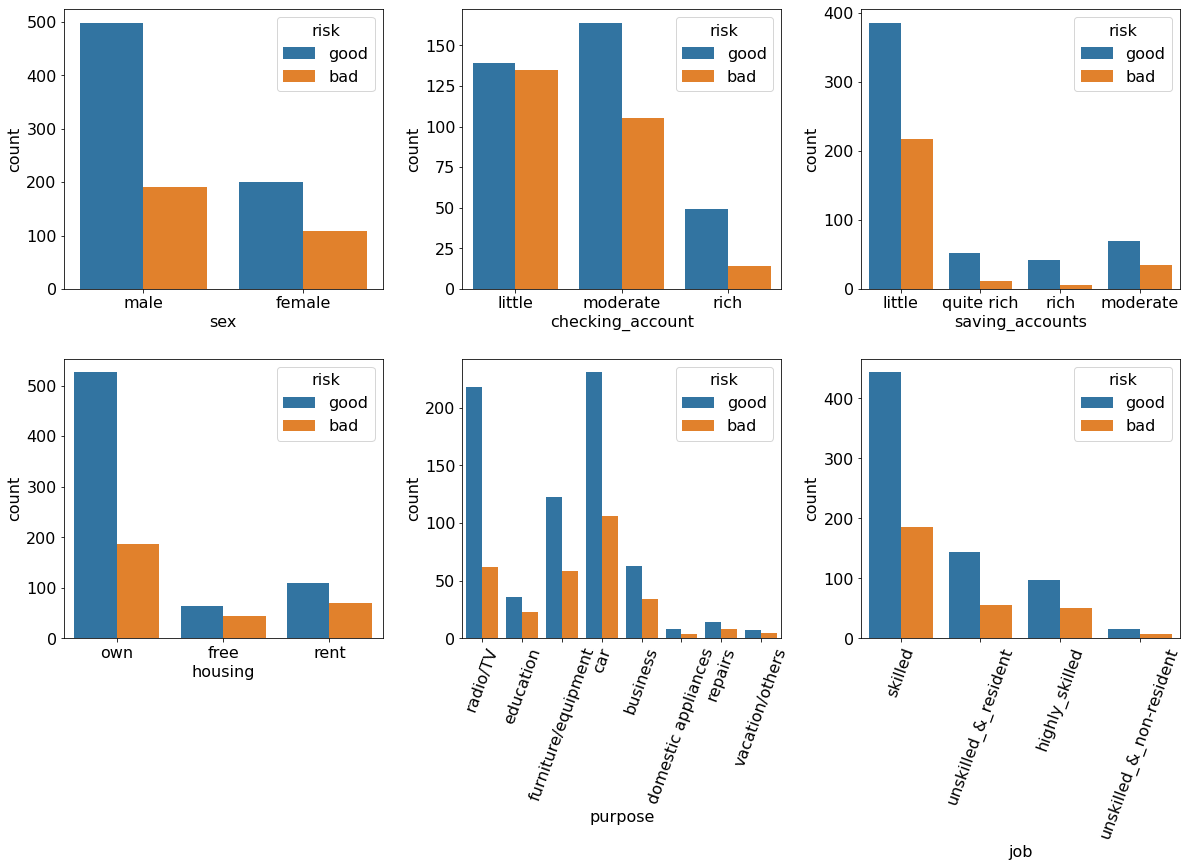

In [ ]:
plt.figure(figsize=(20, 18))

plt.subplot(331)
ax1 = sns.countplot(data = df, x = 'sex', hue="risk", palette='tab10')

plt.subplot(332)
ax2 =  sns.countplot(data = df, x = 'checking_account', hue="risk", palette='tab10')

plt.subplot(333)
ax3 = sns.countplot(data = df, x = 'saving_accounts', hue="risk", palette= 'tab10')

plt.subplot(334)
ax4 = sns.countplot(data = df, x = 'housing', hue="risk", palette= 'tab10')

plt.subplot(335)
ax5 = sns.countplot(data = df, x = 'purpose', hue="risk", palette= 'tab10')
plt.xticks(rotation = 70)

plt.subplot(336)
ax6 = sns.countplot(data = df, x = 'job', hue="risk", palette= 'tab10')
plt.xticks(rotation = 70)

plt.subplots_adjust(wspace=0.25, hspace=0.25)
plt.show()

Analisando os gráficos dispostos acima, observa-se que: 

> - O número de clientes do gênero feminino (female) é proporcionalmente 1/3 do gênero masculino (male). E elas, são menos propensas a inadimplência.;
>
> - A distribuição majoritaria de clientes corresponde a um status de conta corrente equivalente a individuos de baixa renda (`little`) ou renda média (`moderate`), cujo os primeiros, oferencem maior risco de inadimplência. 
>
> - O hábito de poupar dinheiro não é uma prática difundida entre os clientes, cuja a grande maioria possui status de conta poupança equivalente a baixa renda. E como já esperado, os menos abastados tendem a inadimplência;
>
> - Cerca de 2/3 dos clientes possui casa própria. E 1/3 dos clientes que não possuem casa própria tendem a não ser bons pagadores;
>
> - O motivo mais apontado pelos clientes em solicitar uma carta de crédito é a aquisição de um carro, seguido por rádio/tv e imóvel. E da mesma forma, essas três categorias, apresentam os maiores indicativos de inadimplência. No entanto, proporcionalmente, os clientes tendem a serem mais inadimplentes ao solicitarem empréstimo para educação (`education`), empreendedorismo (`business`) e férias (`vacation`);
>
> - A maioria dos inadimplentes são cidadãos alemães cuja a força de trabalho é qualificada (`skilled`), seguidos pelos alemães cuja a mão de obra é não qualificada. Todavia, proporcionalmente, os clientes cuja mão de obra é altamente qualificada (`highly_skilled`), são mais sucetiveis a inadimplência. 

Usando apenas estatística descritiva, obteve-se informações valiosas que fomentam uma tomada de decisão aprimorada por parte da gerência do banco sobre como prosseguir com o solicitante da carta de crédito. Agora, construindo um modelo preditivo por meio do dataset, pode-se aprimorar ainda mais as chances de emitir bons empréstimos (ganho financeiro) e minimizar empréstimos ruins (perda financeira). 

## **5. Feature Engineering & Construção do Modelo: Pipelines**

Uma vez efetuada a EDA, vamos escrever o código que contempla o processo de feature engineering através de pipelines do scikit-learn.

**5.1 Feature Engineering**


In [ ]:
# Dividindo os dados em conjunto de feature e target
features  = df.drop(['risk'], axis=1)
target = df['risk']

numeric_features = ['age', 'credit_amount', 'duration']
categorical_features = ['sex', 'job', 'housing', 'saving_accounts', 'checking_account', 'purpose']

# Pipeline para pré-processamento das variáveis numéricas
numeric_preprocessor = Pipeline(steps=[
    ('robust', RobustScaler()),
    ('scaler', MinMaxScaler())])

# Pipeline para pré-processamento das variáveis categóricas
categorical_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='none')),
    ('one_hot_enc', OneHotEncoder())])

# Compondo os pré-processadores para formar o pipeline completo
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_preprocessor, numeric_features),
    ('cat', categorical_preprocessor, categorical_features)])

# Ajustando e Transformando os dados.
X_features_data_prepared = preprocessor.fit_transform(features)
y_target_data_prepared = LabelEncoder().fit_transform(target)

# Visualizar pipeline 
set_config(display='diagram')
display(preprocessor)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('robust', RobustScaler()),
                                                 ('scaler', MinMaxScaler())]),
                                 ['age', 'credit_amount', 'duration']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='none',
                                                                strategy='constant')),
                                                 ('one_hot_enc',
                                                  OneHotEncoder())]),
                                 ['sex', 'job', 'housing', 'saving_accounts',
                                  'checking_account', 'purpose'])])

**5.2 Construção dos Modelos: KNN, Decision Tree e Naive Bayes**

|

Não há como ter multiplos modelos de classificação como etapas do Pipeline, pois ele só admite um e deve ser a última etapa.


O motivo é simples: Os classifiers geralmente não possuem o método transform, o que é um requisito das etapas internas do Pipeline do SKlearning. E se quisermos testar diversos hiperparâmetros para decidir qual o melhor conjunto para um dado modelo... vish complicou mais ainda! 





Felizmente existe uma maneira muito elegante de fazer isso utilizando programação orientada a objetos, onde podemos criar nossa própria pipeline customizada chamada de `TuringEstimatorSelector`.

A ideia aqui é bem simples, você passa para uma classe dois dicionários: os modelos e os parâmetros; então você chama o método fit, espera até que tudo rode, e depois chama o método score_summary() para ter um bom DataFrame com o relatório de cada instância do modelo, de acordo com os melhores hiperparâmetros.


In [ ]:
class TuringEstimatorSelector:

    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Alguns estimadores estão sem parâmetros: %s" % missing_params)
        self.models = models 
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv=10, scoring=None, n_jobs=-1, verbose=1, refit=True):
        def fluxogram(): # função parar exibir diagrama de blocos
            return display(gs)           
        for key in self.keys:
            print("Executando GridSearchCV para %s." % key)
            model = self.models[key]
            params = self.params[key]
            scores_dict = {
               'accuracy' :make_scorer(accuracy_score),
               'recall'   :make_scorer(recall_score),
               'precision':make_scorer(precision_score),
               'f1'       :make_scorer(fbeta_score, beta = 1)
            }            
            gs = GridSearchCV(model, params, cv=cv, n_jobs=-1, scoring = scores_dict,
                              verbose=verbose, refit='f1', return_train_score=True)                        
            gs.fit(X,y)            
            self.grid_searches[key] = gs            
            fluxogram()

    def score_summary(self):
          model_list = []          
          for m in self.grid_searches:
              # obter nome do modelo para rotular o DataFrame final:                
              model_name = str(self.grid_searches[m].estimator) 
              # obter diversas métricas - fazer subset e gerar DataFrame:         
              temp_df = pd.DataFrame(self.grid_searches[m].cv_results_)[
                                              ['params',
                                              'mean_test_accuracy',          
                                              'mean_test_recall',
                                              'mean_test_precision',
                                              'mean_test_f1']].query('mean_test_f1 == mean_test_f1.max()')
              '''
              Inclui os DataFrames de modelos com os melhores hyperparâmetros  
              numa lista e adiciona a coluna "model" em cada DataFrame:
              '''                                                                                             
              model_list.append(temp_df.assign(model=model_name))
              del temp_df                    
          # Concatena a lista de Dataframes:
          models_grid_df = pd.concat(model_list)
          # Move a coluna "model" para o inicio do DataFrame
          shiftPos = models_grid_df.pop("model"); models_grid_df.insert(0, "model", shiftPos)          
          return models_grid_df

No código acima, em cada objeto `GridSearchCV` criado, testa-se cada hyperparâmetro correspondente ao seu respectivo modelo de pipeline. No caso, os hiperparâmetros foram tunados com `cv = 10` para o gridsearch realizar a validação cruzada em nosso conjunto de dados e `scoring = 'accuracy'` como métrica para obtermos uma avaliação de cada modelo. Vale resssaltar que cv = 10 é um valor escolhido arbitrariamente, no apendice esse parâmetro é explicado.



Para automatizar a parte do processo de tuning dos modelos de machine learning, utilizei o módulo GridSearchCV para ajustar os modelos. As métricas que podem ser utilizadas para avaliar cada conjunto de parâmetros simulados pelo `GridSearchCV` podem ser:

* _recall_;
* _precision_;
* _accuracy_;
* f1, ou;
* fbeta_score (Obs.: Note que o `f1` é um caso específico do `fbeta_score` quando `beta = 1`.).

E para não limitar a avaliação do modelo utilizando apenas uma só métrica, utilizei o `make_scorer` que é um módulo do Scikit Learn que possibilita o `GridSearchCV` calcular e armazenar multiplas métricas no objeto do `GridSearchCV`.






Sem mais delongas agora que temos tudo pronto vamos utilizar 
o transformador customizado `TuringEstimatorSelector`! 

Primeiro devemos usar dois dicionarios: O primeiro serve para armazenar os classfiers e o segundo os hiperparâmetros: 

In [ ]:
# Dicionário com os classificadores.
classifiers = {'knn': KNeighborsClassifier(),
               'dt': DecisionTreeClassifier(),
               'nb': BernoulliNB()}

# Parametros de todos os classifiers para o GridSearchCV testar.
hyperparameters = {'knn': {'n_neighbors' : np.arange(5, 15, 2),
                           'weights'     : ['uniform','distance'],
                           'metric'      : ['minkowski','euclidean','manhattan']
                          },
                    'dt': {'criterion'   : ['gini', 'entropy'],
                           'max_depth'   : np.arange(3, 6, 1)
                          },
                    'nb': {'alpha'       : np.arange(0.01, 0.1, 0.01),
                           'fit_prior'   : [True, False]}
                  }

Já temos toda a parte do _classifier_ pronta juntamente com a definição dos hiperparâmetros.  Agora finalmente vamos fitar os modelos: 

In [ ]:
results = TuringEstimatorSelector(classifiers, hyperparameters)
results.fit(X_features_data_prepared, y_target_data_prepared, refit = 'f1', n_jobs=-1)

Executando GridSearchCV para knn.
Fitting 10 folds for each of 30 candidates, totalling 300 fits


GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['minkowski', 'euclidean', 'manhattan'],
                         'n_neighbors': array([ 5,  7,  9, 11, 13]),
                         'weights': ['uniform', 'distance']},
             refit='f1', return_train_score=True,
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1': make_scorer(fbeta_score, beta=1),
                      'precision': make_scorer(precision_score),
                      'recall': make_scorer(recall_score)},
             verbose=1)

Executando GridSearchCV para dt.
Fitting 10 folds for each of 6 candidates, totalling 60 fits


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([3, 4, 5])},
             refit='f1', return_train_score=True,
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1': make_scorer(fbeta_score, beta=1),
                      'precision': make_scorer(precision_score),
                      'recall': make_scorer(recall_score)},
             verbose=1)

Executando GridSearchCV para nb.
Fitting 10 folds for each of 18 candidates, totalling 180 fits


GridSearchCV(cv=10, estimator=BernoulliNB(), n_jobs=-1,
             param_grid={'alpha': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]),
                         'fit_prior': [True, False]},
             refit='f1', return_train_score=True,
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1': make_scorer(fbeta_score, beta=1),
                      'precision': make_scorer(precision_score),
                      'recall': make_scorer(recall_score)},
             verbose=1)

Vale ressaltar que sem definir uma estratégia de escolha é muito difícil prever o melhor conjunto de hiperparâmetros. Dessa maneira, definiu-se o `refit` para que o `GridSearchCV` possa eleger a melhor solução quando solicitado. No presente estudo de caso, foi definido `f1` como estratégia de escolha, logo o `f1` é a "prova dos nove" para o melhor conjunto de hiperparâmetros de cada modelo de classificação. 

Para imprimir as melhores métricas dentre o conjunto de parâmetros utilizei uma _query_ para selecionar um conjunto de parâmetros. Conforme estipulado, definiu-se o conjunto com o maior valor de `f1` e imprimiu-se os valores de `accuracy`, `recall`, `precision` e `f1`. 

In [ ]:
pd.set_option('display.max_colwidth', None)
display(results.score_summary())

,model,params,mean_test_accuracy,mean_test_recall,mean_test_precision,mean_test_f1
8,KNeighborsClassifier(),"{'metric': 'minkowski', 'n_neighbors': 13, 'weights': 'uniform'}",0.726,0.911429,0.751317,0.823220
18,KNeighborsClassifier(),"{'metric': 'euclidean', 'n_neighbors': 13, 'weights': 'uniform'}",0.726,0.911429,0.751317,0.823220
0,DecisionTreeClassifier(),"{'criterion': 'gini', 'max_depth': 3}",0.720,0.902857,0.750235,0.818738
0,BernoulliNB(),"{'alpha': 0.01, 'fit_prior': True}",0.706,0.782857,0.796359,0.788444


De acordo com a tabela acima, baseando-se na métrica `f1`, as melhores soluções correspondem ao modelo `KNN` com os seguintes conjutos de hiperparâmetros: `{'metric': 'minkowski', 'n_neighbors': 13, 'weights': 'uniform'}` ou `{'metric': 'euclidean', 'n_neighbors': 13, 'weights': 'uniform'}`. Plotando a matriz de confusão:

In [ ]:
#class_names=np.array(['0','1'])
def plot_confusion_matrix(cf_matrix):            
    group_names = ['Verdadeiro Negativo','Falso Positivo','Falso Negativo','Verdadeiro Positivo']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize=(8,6)); ax = sns.heatmap(cf_matrix, annot=labels, fmt='',annot_kws={"fontsize":13},cmap="Blues")
    ax.set_title('Matriz de Confusão'); ax.set_xlabel('\nPredito', fontsize=14); ax.set_ylabel('Real', fontsize=14);
    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['Mal Pagador','Bom pagador'],fontsize=14)
    ax.yaxis.set_ticklabels(['Mal Pagador','Bom pagador'],fontsize=14)
    ## Display the visualization of the Confusion Matrix.
    plt.show()

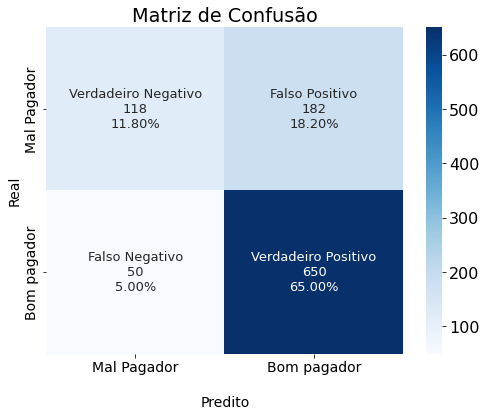

None

In [ ]:
 # Instanciando o KNN com os melhores parâmetros e fitando o modelo
knn_model = KNeighborsClassifier(metric = 'minkowski', n_neighbors = 13, weights = 'uniform')
knn_model.fit(X_features_data_prepared, y_target_data_prepared)
# Testando o modelo
y_pred = knn_model.predict(X_features_data_prepared)
# Matriz Confusão
cf_matrix = metrics.confusion_matrix(y_target_data_prepared, y_pred)
display(plot_confusion_matrix(cf_matrix))

Logo podemos ver que o modelo KNN fez um ótimo trabalho ao prever a inadimplência observando os verdadeiros positivos na diagonal.

## **Apêndice**

De forma complementar segue uma discussão mais detalhada a respeito do método GridSearch. Nesse caso irei considerar apenas um modelo:

In [ ]:
# Criando um dicionário com as métricas que desejo calcular.
meus_scores = {'accuracy' :make_scorer(accuracy_score),
               'recall'   :make_scorer(recall_score),
               'precision':make_scorer(precision_score),
               'f1'       :make_scorer(fbeta_score, beta = 1)}

# Criação dos objetos de GridSearchCV.
knn_grid = GridSearchCV(estimator = classifiers['knn'],          
                    param_grid = hyperparameters['knn'],  
                    scoring = meus_scores,
                    refit = 'f1', # Escolhi essa métrica para decidir qual são os melhores hiperparâmetros            
                    cv = 10)

# Fitando o modelo:
knn_grid_model = knn_grid.fit(X_features_data_prepared, y_target_data_prepared)

Vamos analisar o atributo `.cv_results_` de qualquer um dos modelos para verificar se houve a adição das colunas com os valores das métricas desejadas.

In [ ]:
# Fazendo uma subamostragem. 
pd.DataFrame(knn_grid_model.cv_results_).columns.tolist()

['mean_fit_time',
 'std_fit_time',
 'mean_score_time',
 'std_score_time',
 'param_metric',
 'param_n_neighbors',
 'param_weights',
 'params',
 'split0_test_accuracy',
 'split1_test_accuracy',
 'split2_test_accuracy',
 'split3_test_accuracy',
 'split4_test_accuracy',
 'split5_test_accuracy',
 'split6_test_accuracy',
 'split7_test_accuracy',
 'split8_test_accuracy',
 'split9_test_accuracy',
 'mean_test_accuracy',
 'std_test_accuracy',
 'rank_test_accuracy',
 'split0_test_recall',
 'split1_test_recall',
 'split2_test_recall',
 'split3_test_recall',
 'split4_test_recall',
 'split5_test_recall',
 'split6_test_recall',
 'split7_test_recall',
 'split8_test_recall',
 'split9_test_recall',
 'mean_test_recall',
 'std_test_recall',
 'rank_test_recall',
 'split0_test_precision',
 'split1_test_precision',
 'split2_test_precision',
 'split3_test_precision',
 'split4_test_precision',
 'split5_test_precision',
 'split6_test_precision',
 'split7_test_precision',
 'split8_test_precision',
 'split9_test_

Conforme esperado, agora o objeto `grid` possui todas as métricas desejadas para uma análise detalhada. Observe que foram feitas 10 simulações para cada conjunto de parâmetros (que vc pode visualizar na coluna `params`). Ao passo que "train" e "test" referem-se à divisão do _dataset_ em treino e test, note que o `GridSearchCV` já faz isso automaticamente!! Logo, não há necessidade de dividir o _dataset_ usando o `train_test_split` antes de treinar o seu objeto `grid`, pois quando o parâmetro `cv` é configurado para um número inteiro (neste caso 10) é feito "ocultamente" um `StratifiedKFolds`, conforme pode ser confirmado na documentação do módulo `GridSearchCV`.


